In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pycopula.copula import ArchimedeanCopula
from mpl_toolkits.mplot3d import Axes3D
from pycopula.visualization import pdf_2d, cdf_2d
from pycopula.visualization import concentrationFunction
from pycopula.simulation import simulate


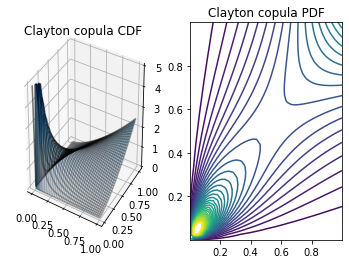

In [2]:

# The Clayton copula
clayton = ArchimedeanCopula(family="clayton", dim=2)

# Visualization of CDF and PDF
u, v, C = cdf_2d(clayton)
u, v, c = pdf_2d(clayton)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d', title="Clayton copula CDF")
X, Y = np.meshgrid(u, v)

ax.set_zlim(0, 5)
ax.plot_surface(X, Y, c, cmap=cm.Blues)
ax.plot_wireframe(X, Y, c, color='black', alpha=0.3)

ax = fig.add_subplot(122, title="Clayton copula PDF")
ax.contour(X, Y, c, levels = np.arange(0,5,0.15))

plt.show()

import pandas as pd
from pycopula.copula import ArchimedeanCopula



archimedean = ArchimedeanCopula(family="gumbel", dim=2)
archimedean.fit(data, method="cmle")

In [3]:
import numpy as np

x1 = np.random.uniform(size=30000)
x2 = np.random.uniform(size=30000)
X = np.vstack((x1, x2)).T


In [4]:
archim = ArchimedeanCopula(family="clayton", dim=2)
fittedClayton = archim.fit(X, method="cmle")
archim

In [5]:
u, v, C = cdf_2d(archim)
u, v, c = pdf_2d(archim)

NameError: name 'fi' is not defined

In [ ]:
?